## Import Packages

In [105]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [29]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

## Loading the Data

In [38]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ["C:\\Users\\mawat\\Downloads\\image classification\\seg_train\\seg_train", 'C:\\Users\\mawat\\Downloads\\image classification\\seg_test\\seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [39]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\Users\mawat\Downloads\image classification\seg_train\seg_train


100%|██████████| 2382/2382 [00:05<00:00, 407.92it/s]


Loading C:\Users\mawat\Downloads\image classification\seg_test\seg_test


100%|██████████| 501/501 [00:01<00:00, 375.88it/s]


In [40]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

## Exploring Dataset

In [41]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


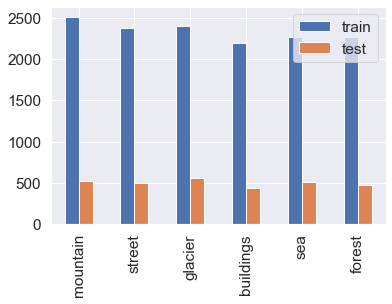

In [42]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

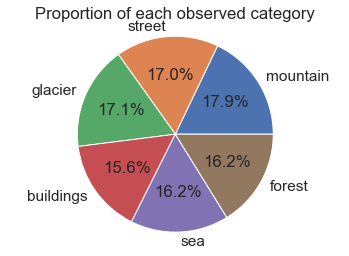

In [43]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Good practise: Scale the data

In [44]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualize the data

In [45]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

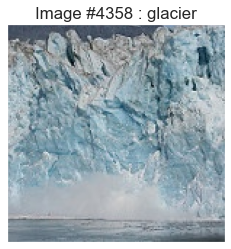

In [46]:
display_random_image(class_names, train_images, train_labels)

In [47]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

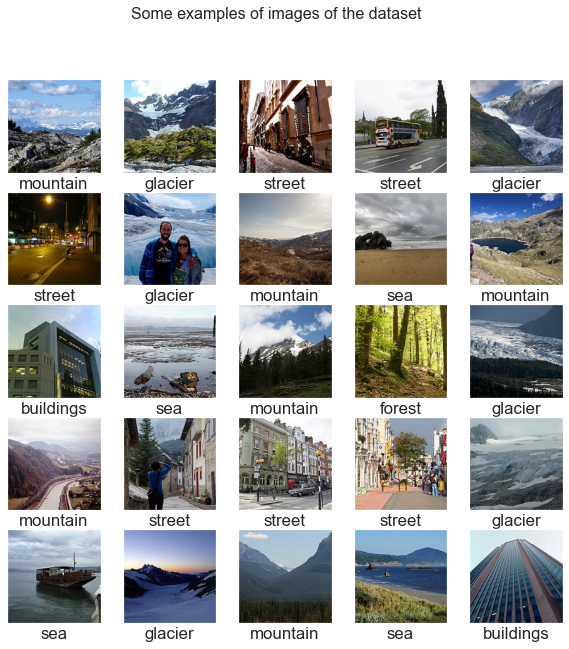

In [48]:
display_examples(class_names, train_images, train_labels)

## Simple Model Creation
Steps
1. Build and compile the model
2. Train/fit the data to the model
3. Evaluate the model on the testing data
4. Carry out an error analysis of the model

We can build an easy model composed of different layers such as:
1. Conv2D: (32 filters of size 3 by 3) The feature will be 'extracted' from the image.
2. MaxPooling2D: The images get half sized
3. Flatten: Transforms the format of the images from a 2D array to 1D array of 150 X 150 X 3 pixel values
4. Relu: Give a value x, returns max(x,0)
5. Softmax: 6 neurons, probability that the image belongs to one of the classes

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Then we can compile it with some parameters such as:
1. Optimizer: adam = RMSProp + Momentum.
              Momentum: takes into account past gradient to have a better update
              RMSProp: exponentially wweighted average of the squares of past gradients
2. Loss function: We use sparse categorical crossentropy for classification, each images belongs to one class only

In [50]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

We fit the model to the data from the training set. The nummerical network will learn by itself the pattern in order to distinguish each category.

In [51]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 136s 2s/step - loss: 1.2826 - accuracy: 0.5196 - val_loss: 0.8962 - val_accuracy: 0.6551
Epoch 2/20
88/88 [==============================] - 131s 1s/step - loss: 0.7558 - accuracy: 0.7183 - val_loss: 0.7442 - val_accuracy: 0.7157
Epoch 3/20
88/88 [==============================] - 133s 2s/step - loss: 0.5613 - accuracy: 0.8000 - val_loss: 0.6881 - val_accuracy: 0.7531
Epoch 4/20
88/88 [==============================] - 133s 2s/step - loss: 0.4357 - accuracy: 0.8477 - val_loss: 0.6633 - val_accuracy: 0.7663
Epoch 5/20
88/88 [==============================] - 130s 1s/step - loss: 0.3211 - accuracy: 0.8962 - val_loss: 0.6917 - val_accuracy: 0.7667
Epoch 6/20
88/88 [==============================] - 124s 1s/step - loss: 0.2183 - accuracy: 0.9338 - val_loss: 0.8054 - val_accuracy: 0.7538
Epoch 7/20
88/88 [==============================] - 107s 1s/step - loss: 0.1654 - accuracy: 0.9503 - val_loss: 0.8104 - val_accuracy: 0.7670
Epoch 8/20
88

In [88]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = 'accuracy')
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

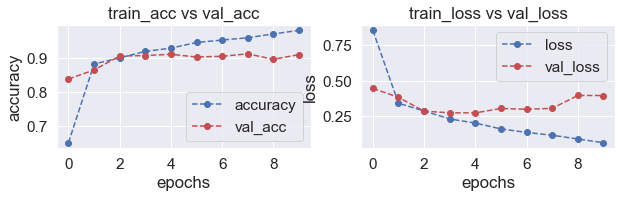

In [89]:
plot_accuracy_loss(history)

We should evaluate the model performance on test set

In [59]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 6s 60ms/step - loss: 1.2648 - accuracy: 0.7610


We see that we achieve 0.76 accuracy on the testing. We got a slight underfitting.
Checking the classifier on random images.

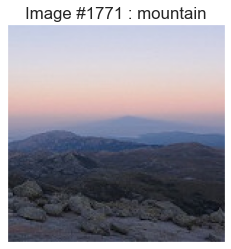

In [60]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

## Error Analysis
Trying to understand on which kind of images the classifier has trouble.

In [61]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

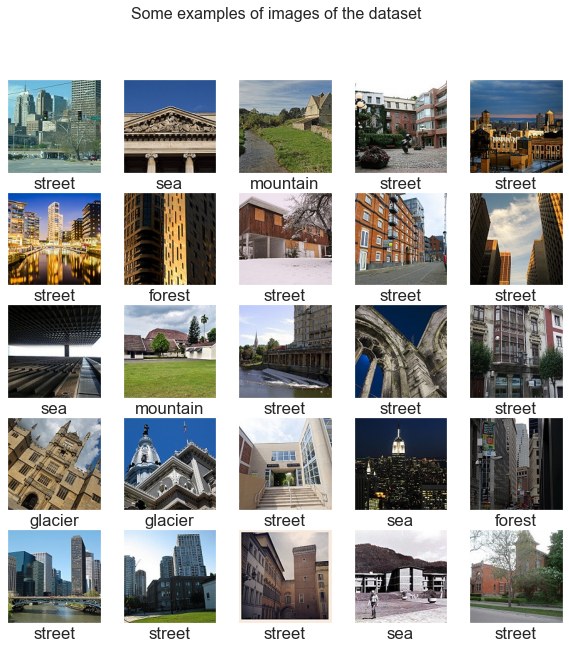

In [62]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

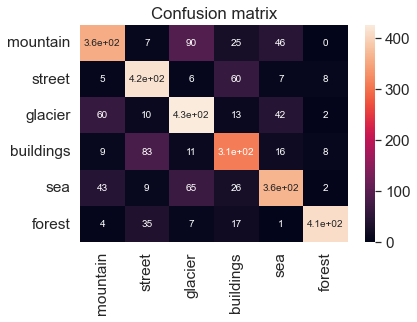

In [63]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

The classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. It also has trouble with sea, glacier and mountain.

## Feature extraction with VGG16 ImageNet

In [65]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 17s 0us/step


In [66]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

## Visualizing the features through PCA

In [67]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [68]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

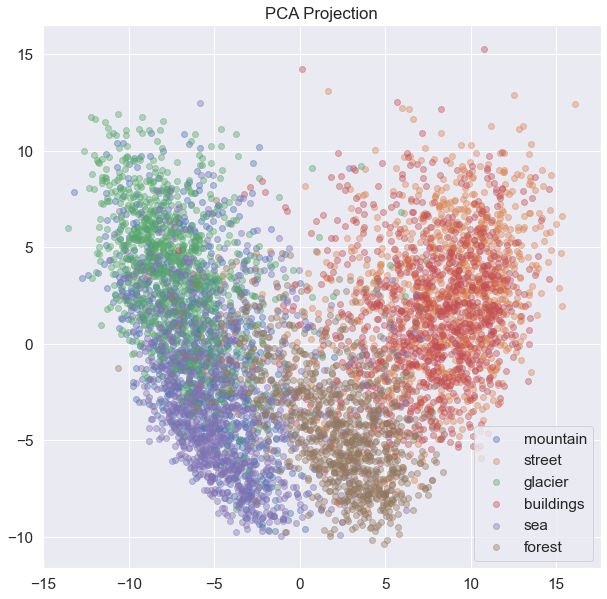

In [69]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

We can identify clusters with PCA. The clusters correspond more or less to the labels.
We can see that glacier and mountain points are very close to each other, as VGG sees them as very similar.
We see that there is no distinction between building and street.

## Training on top of VGG
Training a simple 1-layer Neural Network on the features extracted from VGG

In [70]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 7ms/step - loss: 0.5162 - accuracy: 0.8159 - val_loss: 0.3732 - val_accuracy: 0.8636
Epoch 2/15
88/88 [==============================] - 1s 6ms/step - loss: 0.2883 - accuracy: 0.8969 - val_loss: 0.3190 - val_accuracy: 0.8821
Epoch 3/15
88/88 [==============================] - 1s 6ms/step - loss: 0.2333 - accuracy: 0.9187 - val_loss: 0.3437 - val_accuracy: 0.8728
Epoch 4/15
88/88 [==============================] - 1s 6ms/step - loss: 0.1946 - accuracy: 0.9326 - val_loss: 0.3330 - val_accuracy: 0.8760
Epoch 5/15
88/88 [==============================] - 1s 6ms/step - loss: 0.1533 - accuracy: 0.9516 - val_loss: 0.3324 - val_accuracy: 0.8799
Epoch 6/15
88/88 [==============================] - 1s 6ms/step - loss: 0.1276 - accuracy: 0.9607 - val_loss: 0.3326 - val_accuracy: 0.8828
Epoch 7/15
88/88 [==============================] - 1s 6ms/step - loss: 0.1085 - accuracy: 0.9672 - val_loss: 0.3468 - val_accuracy: 0.8821
Epoch 8/15
88/88 [==

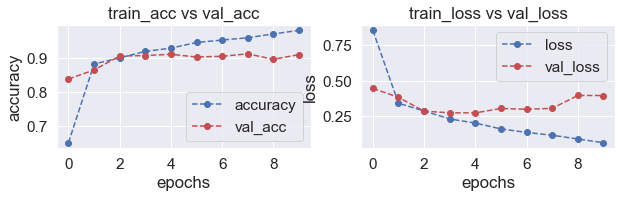

In [90]:
plot_accuracy_loss(history)

We should get approximately 0.844 accuracy (+0.1 accuracy) over the simple ConvNet

In [72]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.8730


## Ensemble Neural Networks

In [73]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

We define n_estimators Neural Networks
Each neural network will be trained on random subsets of the training dataset.
Each subset contains 'max_samples' samples.

In [74]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [75]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
79/79 [==============================] - 2s 24ms/step - loss: 0.5062 - accuracy: 0.8134 - val_loss: 0.3105 - val_accuracy: 0.8949
Epoch 2/10
79/79 [==============================] - 1s 7ms/step - loss: 0.2555 - accuracy: 0.9091 - val_loss: 0.2326 - val_accuracy: 0.9225
Epoch 3/10
79/79 [==============================] - 1s 7ms/step - loss: 0.1771 - accuracy: 0.9446 - val_loss: 0.2215 - val_accuracy: 0.9216
Epoch 4/10
79/79 [==============================] - 1s 7ms/step - loss: 0.1370 - accuracy: 0.9577 - val_loss: 0.1921 - val_accuracy: 0.9341
Epoch 5/10
79/79 [==============================] - 1s 7ms/step - loss: 0.1015 - accuracy: 0.9720 - val_loss: 0.1902 - val_accuracy: 0.9394
Epoch 6/10
79/79 [==============================] - 1s 7ms/step - loss: 0.0884 - accuracy: 0.9746 - val_loss: 0.1789 - val_accuracy: 0.9386
Epoch 7/10
79/79 [==============================] - 1s 7ms/step - loss: 0.0643 - accuracy: 0.9850 - val_loss: 0.1701 - val_accuracy: 0.9492
Epoch 8/10
79/79 [=

79/79 [==============================] - 1s 7ms/step - loss: 0.0309 - accuracy: 0.9945 - val_loss: 0.2431 - val_accuracy: 0.9332
Epoch 10/10
79/79 [==============================] - 1s 7ms/step - loss: 0.0240 - accuracy: 0.9965 - val_loss: 0.2443 - val_accuracy: 0.9359
Epoch 1/10
79/79 [==============================] - 1s 9ms/step - loss: 0.5190 - accuracy: 0.8076 - val_loss: 0.3291 - val_accuracy: 0.8842
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 0.2544 - accuracy: 0.9106 - val_loss: 0.2605 - val_accuracy: 0.8985
Epoch 3/10
79/79 [==============================] - 1s 7ms/step - loss: 0.1826 - accuracy: 0.9375 - val_loss: 0.2188 - val_accuracy: 0.9279
Epoch 4/10
79/79 [==============================] - 1s 7ms/step - loss: 0.1217 - accuracy: 0.9647 - val_loss: 0.2063 - val_accuracy: 0.9252
Epoch 5/10
79/79 [==============================] - 1s 7ms/step - loss: 0.0975 - accuracy: 0.9734 - val_loss: 0.1918 - val_accuracy: 0.9350
Epoch 6/10
79/79 [============

We aggregate each model individual predictions to form a final prediction

In [76]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

We should improve our result as we have a lower variance

In [77]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.89


## Fine Tuning VGG ImageNet

In [78]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [79]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [80]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [81]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [82]:
new_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 9, 9, 512)]       0         
_________________________________________________________________
block5_conv1 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          294976    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)         

In [83]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 168s 2s/step - loss: 0.8543 - accuracy: 0.6519 - val_loss: 0.4454 - val_accuracy: 0.8375
Epoch 2/10
88/88 [==============================] - 156s 2s/step - loss: 0.3408 - accuracy: 0.8813 - val_loss: 0.3819 - val_accuracy: 0.8639
Epoch 3/10
88/88 [==============================] - 151s 2s/step - loss: 0.2859 - accuracy: 0.8993 - val_loss: 0.2848 - val_accuracy: 0.9045
Epoch 4/10
88/88 [==============================] - 159s 2s/step - loss: 0.2299 - accuracy: 0.9180 - val_loss: 0.2733 - val_accuracy: 0.9059
Epoch 5/10
88/88 [==============================] - 160s 2s/step - loss: 0.2010 - accuracy: 0.9276 - val_loss: 0.2726 - val_accuracy: 0.9095
Epoch 6/10
88/88 [==============================] - 150s 2s/step - loss: 0.1595 - accuracy: 0.9440 - val_loss: 0.3037 - val_accuracy: 0.9017
Epoch 7/10
88/88 [==============================] - 150s 2s/step - loss: 0.1351 - accuracy: 0.9512 - val_loss: 0.2982 - val_accuracy: 0.9038
Epoch 8/10
88

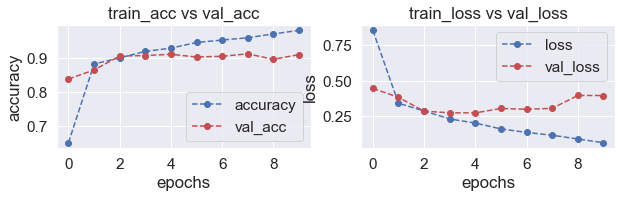

In [91]:
plot_accuracy_loss(history)

In [85]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8986666666666666
